**Processamento Digital de Imagens - 2022/01**<br/>
**Engenharia da Computação**<br/>
**Aluno:** Gabriel Soares Baptista, 2018102117<br/>

### Questão 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from PIL import Image

## Funções Auxiliares

In [2]:
def convolution_median_filter(image: np.array, order: int) -> np.array:
    '''
    Aplica a máscara de mediana pela convolução. Note que estamos utilizando
    uma padding replicando os valores das bordas para uma melhor aproximação.
    '''
    half = order//2
    result = np.zeros(shape=(image.shape))
    M, N = image.shape[:2]

    padded = np.pad(image, half, mode='edge')

    for i in range(half, M + half):
        for j in range(half, N + half):
            result[i - half, j - half] = np.median(padded[i-half:i+half, j-half:j+half])

    return result


def image_normalize(image: np.array) -> np.array:
    '''
    Normaliza os valores da imagens para o intervalo [0, 255].
    '''
    v_min = float(image.min())
    v_max = float(image.max())
    normalized_image = np.round((image - v_min)/(v_max - v_min) * 255)
    return np.array(normalized_image, dtype=np.uint8)


def compute_otsu_criteria(image: np.array, threshold: int) -> float:
    '''
    Calcula otsu para a imagem e threshold específicos.
    '''
    # fill mask with 0 and 1
    mask = np.where(image >= threshold, 1, 0)

    # compute weights
    weight_non_zero = mask.flatten().sum() / image.size
    weight_zero = 1 - weight_non_zero

    # check weights
    if weight_zero == 0 or weight_non_zero == 0:
        return np.inf

    # get marked pixels
    non_zero_pixels = image[mask == 1]
    zero_pixels = image[mask == 0]

    # compute variance
    var0 = np.var(zero_pixels) if len(zero_pixels) > 0 else 0
    var1 = np.var(non_zero_pixels) if len(non_zero_pixels) > 0 else 0

    return weight_zero * var0 + weight_non_zero * var1


def otsu(image: np.array) -> np.array:
    '''
    Aplica o método de limiarização de Otsu e retorna a imagem informada binarizada.
    '''
    # compute thresholds
    threshold_range = range(1, np.max(image) + 1)
    criterias = [compute_otsu_criteria(image, threshold)
                 for threshold in threshold_range]
    
    # get best threshold
    best_threshold = threshold_range[np.argmin(criterias)]

    return np.where(image > best_threshold, 255, 0)


def multiple_otsu(
    image: np.array,
    horizontal_splits: int,
    vertical_splits: int):
    '''
    Aplica o método de Otsu repartindo a imagem na quantidade de divisões
    informadas verticalmente e horizontalmente.
    '''
    N, M = image.shape
    h_step = M // horizontal_splits
    v_step = N // vertical_splits

    segmented_image = np.zeros(shape=(N, M))

    for i in range(0, N, v_step):
        for j in range(0, M, h_step):
            segmented_image[i:i+v_step, j:j+h_step] = otsu(image[i:i+v_step, j:j+h_step])

    return segmented_image


### Resolução

Primeiro lemos a imagem que iremos segmentar.

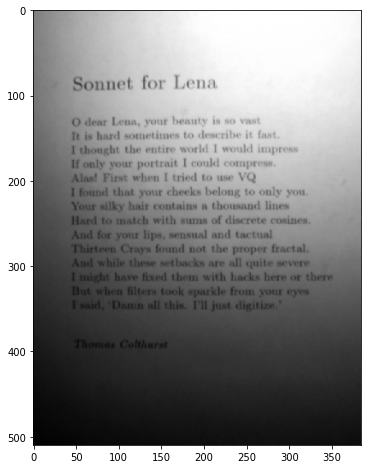

In [3]:
image = skimage.io.imread('../images/carta.gif')

plt.figure(figsize=(6, 8))
plt.imshow(image, cmap='gray')
plt.show()

Aqui vemos que, embora a imagem possua 3 canais, trata-se de uma imagem em tons de cinza. Portanto, a segmentação pode ser feita através de métodos de limiarização como o método de Otsu. Entretanto, a imagem a cima não é praticável para o método, uma vez que possui um forte desnível de iluminação, para resolver esse problema podemos tentar borrar a imagem através de um filtro de mediana, removendo informações de alta frequência (no nosso contexto as transições, tratando-se das letras), portanto, a imagem resultante terá apenas as coisas que mudam lentamente como a iluminação irregular. Logo, podemos subtrair a imagem original pela imagem borrada para resolver parte do problema.

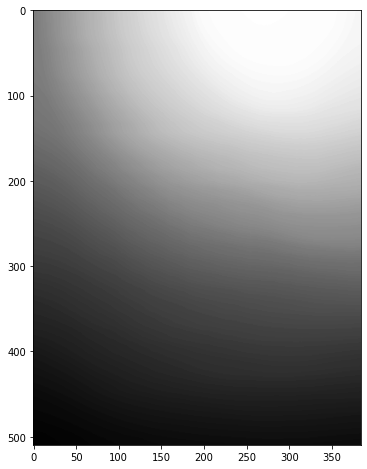

In [4]:
blured_image = convolution_median_filter(image, 100)

plt.figure(figsize=(6, 8))
plt.imshow(blured_image, cmap='gray')
plt.show()


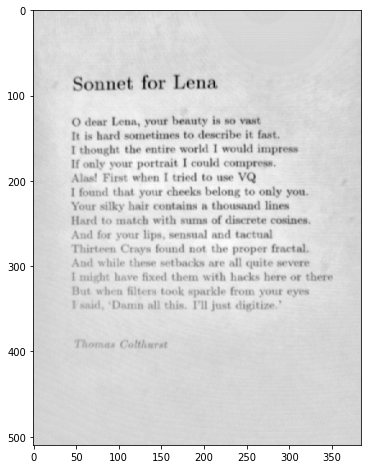

In [5]:
blured_image = image_normalize(image - blured_image)
plt.figure(figsize=(6, 8))
plt.imshow(blured_image, cmap='gray')
plt.show()

Agora podemos utilizar o método de otsu repartindo a imagem em uma quantidade suficiente para suprior o restante da iluminção não constante.

O método de otsu funciona buscando o melhor valor de threshold para binarizar a imagem através do histograma da imagem, isto é, computamos o histograma e as probabilidades de cada intensidade, definimos o peso e média iniciais e, para cada possível valor de threshold no intervalo [1, 255], atualizamos os valores de peso e média computando a variância, escolhendo-se o limite que possua a maior variância.

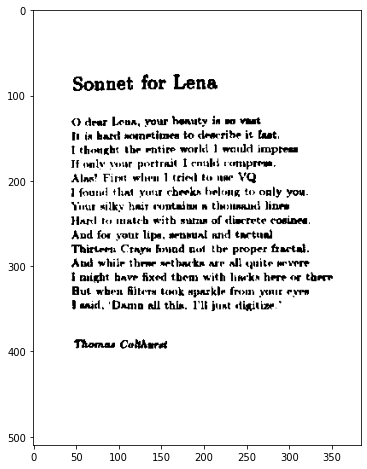

In [6]:
segmented_image = multiple_otsu(blured_image, 4, 2)

plt.figure(figsize=(6, 8))
plt.imshow(segmented_image, cmap='gray')
plt.show()

O método de Otsu é utilizado para limiarização, portanto, a imagem saparada apresenta o objeto em preto e o fundo em branco (a imagem acima está mostrando o fundo), entretanto, podemos mostrar apenas as letras obtendo o complemento da imagem, isto é, apenas invertendo o que selecionamos com o limiar. Este método pode ser utilizado para essa tarefa de segmentação apenas pois estamos interessados em separar o objeto do fundo, i.e. possuimos apenas 2 focos de interesse sendo resolvido por um método binário.

---

A imagem do arroz pode ser resolvida pelo mesmo procedimento.

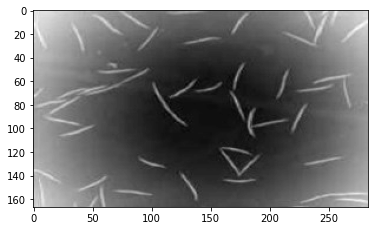

In [7]:
image2 = Image.open('../images/image-segmentation.jpg').convert('L')
image2 = np.array(image2, dtype='uint8')

plt.figure(figsize=(6, 8))
plt.imshow(image2, cmap='gray')
plt.show()

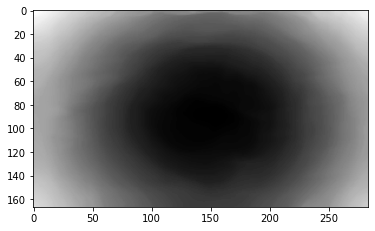

In [8]:
blured_image2 = convolution_median_filter(image2, 25)

plt.figure(figsize=(6, 8))
plt.imshow(blured_image2, cmap='gray')
plt.show()


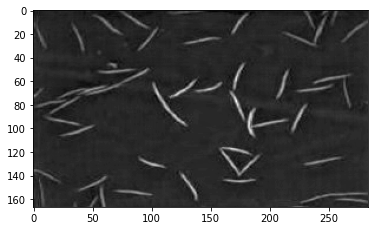

In [9]:
blured_image2 = image_normalize(image2 - blured_image2)
plt.figure(figsize=(6, 8))
plt.imshow(blured_image2, cmap='gray')
plt.show()

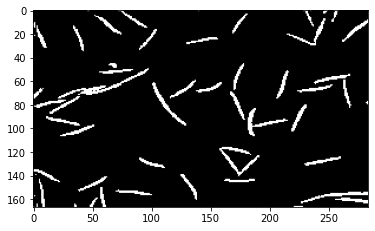

In [10]:
segmented_image2 = multiple_otsu(blured_image2, 10, 1)

plt.figure(figsize=(6, 8))
plt.imshow(segmented_image2, cmap='gray')
plt.show()